# <center>Идентификация пользователей по посещенным веб-страницам

План:  
1. Цели и задачи проекта  
2. Подготовка данных  
3. Первичный анализ данных  
4. Создание новых признаков на основе имеющихся  
5. Визуализация  
6. Обучение модели  
7. Кривые валидации и обучения  
8. Выводы и оценка модели

## 1. Цели и задачи проекта

Идентификация пользователя по его поведению в сети Интернет – это сложная и интересная задача на стыке анализа данных и поведенческой психологии. Эта задача решается как IT-гигантами, так стартапами и научными коллективами. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. Взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду.  
В этом проекте мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, мы будем идентифицировать этого человека.  
Представленно в виде соревнования на kaggle - https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2

## 2. Подготовка данных

In [121]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import fnmatch
import re
import pickle
import pylab 
from collections import Counter
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

**1)** В данных есть время посещения сайта и его название для каждого из 150 пользователей. Делим данные на сессии например по 10. У каждого пользователя получается определенное количество сессий из 10 сайтов. Если для последней сессии не хватает сайтов то заполняем строку нулями.  
**Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов.**  
Признаками – индексы этих 10 сайтов.  
Целевым классом будет id пользователя.

In [31]:
PATH_TO_DATA = 'data'
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, '150users/user0103.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 12:18:58,api.bing.com
1,2013-11-15 12:21:25,ieonline.microsoft.com
2,2013-11-15 12:27:04,www.google.fr
3,2013-11-15 12:27:05,www.google.fr
4,2013-11-15 12:27:06,apis.google.com


**2)** Делаем словарь названий сайтов. Сайт: (порядковый номер, частотность). Если уникальных сайтов всего 15, то длина словаря равна 15. По частотности потом можно будет определить самый популярный сайт как для одного пользователя так и для всех пользователей.  
В матрице заменяем все названия сайтов на порядковые номера из словаря.

In [8]:
def prepare_train_set(path_to_csv_files, session_length=10):
    features = ['site%d' % i for i in range(1, session_length+1)]
    files = fnmatch.filter(os.listdir(path_to_csv_files), '*.csv')
    site_dict = {}
    site_dict_freqs = {}
    df_sum = pd.DataFrame()
    number = 1
    
    for file in files:
        id_user = int(''.join(re.findall(r'[\d]+', file)))
        df = pd.read_csv(path_to_csv_files + '/' + file)
        
        #собираем словарь сайтов
        sites = df['site'].ravel()
        for site in sites:
            if (not site in site_dict): 
                site_dict[site] = number
                number += 1
                
        inv_site_dict = {v: k for (k, v) in site_dict.items()}
        
        #Собираем сессии согласно session_length
        df['site'] = df['site'].map(site_dict)
        remainder = len(df['site'].values)%session_length
        if (remainder > 0): 
            missing = [0 for i in range(session_length - remainder)]
            site_data = np.append(df['site'].values, missing)
        else:
            site_data = df['site'].values
        
        df = pd.DataFrame(site_data.reshape(-1, session_length), columns=features)
        df['user_id'] = id_user
        df_sum = pd.concat([df_sum, df])
        
        #Частотность по каждому сайту
        #site_freqs = Counter(df_sum[features].values.ravel())
        unique, counts = np.unique(df_sum[features].values.ravel(), return_counts=True)
        site_freqs = np.asarray((unique, counts)).T
        
        
    site_dict_freqs = {inv_site_dict[i]: tuple(site_freqs[i]) for i in range(1, len(inv_site_dict)+1)}
    df_sum = df_sum.reset_index(drop=True)
    
    return df_sum, site_dict_freqs

In [32]:
%%time
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'))

CPU times: user 9.64 s, sys: 1.12 s, total: 10.8 s
Wall time: 11.6 s


In [33]:
# Сессии пользователей
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,1,2,2,1,3,2,4,5,6,7,158
1,8,2,9,9,10,9,11,12,13,14,158
2,15,16,9,15,16,13,9,14,16,9,158
3,9,16,9,9,9,17,9,9,14,13,158
4,16,15,15,13,14,16,15,16,9,9,158


In [37]:
# Для дальнейшего анализа запишем полученные объекты DataFrame в csv-файлы.
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), 
                                                       index_label='session_id', float_format='%d')

In [28]:
# Словарь
site_freq_150users['office14client.microsoft.com'], site_freq_150users['api.bing.com']

((1, 259), (3, 4641))

**3)** Делаем мешок слов. Матрицу которая содержит произвольные цифры вместо сайтов надо сделать разреженной матрицей. Каждая колонка в которой будет одним из 15 сайтов. Всего получится 15 колонок вместо 10. А значением будет то сколько раз этот сайт встретился в преобразуемой матрице.

In [34]:
X_150users, y_150users = train_data_150users.iloc[:, :-1].values, train_data_150users.iloc[:, -1].values
sites150_flatten = X_150users.flatten()
X_sparse_150users = csr_matrix(([1] * sites150_flatten.shape[0], 
                                sites150_flatten, range(0, sites150_flatten.shape[0] + 10, 10)))[:, 1:]
X_sparse_150users

<137019x27797 sparse matrix of type '<class 'numpy.int64'>'
	with 1369510 stored elements in Compressed Sparse Row format>

In [35]:
# Сохраняем матрицу и словарь
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'wb') as X150_pkl:
    pickle.dump(X_sparse_150users, X150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'wb') as y150_pkl:
    pickle.dump(y_150users, y150_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

## 3. Первичный анализ данных

**1)** Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [44]:
# train_data_150users['user_id'].value_counts()
# np.unique(train_data_150users.values[0, :-1])
num_unique_sites = [np.unique(train_data_150users.values[i, :-1]).shape[0] 
                                                            for i in range(train_data_150users.shape[0])]
pd.Series(num_unique_sites).value_counts()

7     23913
8     22715
6     21043
9     16275
5     16241
4     11101
3      8106
10     7783
2      5710
1      4132
dtype: int64

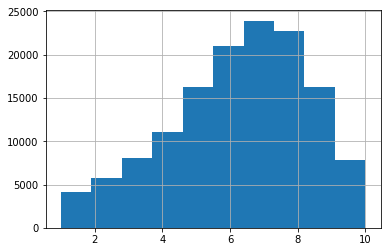

In [49]:
pd.Series(num_unique_sites).hist();

**2)** С помощью QQ-плота и критерия Шапиро-Уилка проверим распределено ли нормально число уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

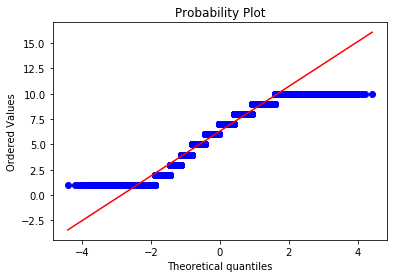

In [52]:
stats.probplot(num_unique_sites, dist="norm", plot=pylab)
pylab.show()

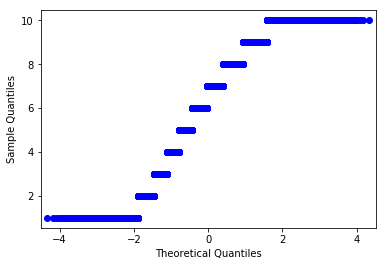

In [56]:
sites = pd.Series(num_unique_sites)
fig = sm.qqplot(sites, loc=sites.mean(), scale=sites.std())
plt.show()

In [57]:
stats.shapiro(sites)

(0.9541171789169312, 0.0)

Распределение не нормальное

## 4. Создание новых признаков на основе имеющихся

Создайте следующие признаки:  
session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)  
unique_sites – число уникальных сайтов в сессии  
start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)  
day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)  

In [61]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', 'unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [71]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    files = fnmatch.filter(os.listdir(path_to_csv_files), '*.csv')
    data = []
    
    with open(site_freq_path, 'rb') as inp_file:
        site_dict = pickle.load(inp_file)
        
    site_dict_map = {k:v[0] for (k, v) in site_dict.items()}
    
    # Проходим с цикле по файлам в папке
    for file in files:
        target = int(''.join(re.findall(r'[\d]+', file)))
        df = pd.read_csv(path_to_csv_files + '/' + file)        
        
        df['site'] = df['site'].map(site_dict_map)
        sites = df['site'].values
        timestamp = df['timestamp'].values
        
        current_start = 0
        current_end = session_length
        sites_len = len(sites)
        session_len = math.ceil(sites_len/window_size)

        # Проходим с цикле по сессиям файла
        for i in range(0, session_len):
            sites_slice = list(sites[current_start:current_end])
            timestamp_slise = list(timestamp[current_start:current_end])
            
            df_sites = sites_slice
            df_missing = []
            
            # Заполняем 0, если у сайтов есть незаполненный остаток в строке
            remainder = len(sites_slice)%session_length
            if (remainder > 0): 
                df_missing = [0 for i in range(session_length - remainder)]
                
            # Считаем продолжительность посещения 2-х ближайших сайтов в сессии
            df_timediff = []
            k = 0
            timestamp_length = len(timestamp_slise)
            for j in timestamp_slise:
                if (k+1 < timestamp_length):
                    df_timediff.append((pd.to_datetime(timestamp_slise[k+1]) - pd.to_datetime(timestamp_slise[k])).seconds)
                k += 1
            df_timediff = df_timediff + [0] * (session_length - timestamp_length)
            
            # Продолжительность сессии 
            df_timespan = (pd.to_datetime(timestamp_slise[-1]) - pd.to_datetime(timestamp_slise[0])).seconds
            
            # Число уникальных сайтов в сессии
            df_unique_sites = len(set(df_sites))
            
            # Час начала сессии
            df_start_hour = pd.to_datetime(timestamp_slise[0]).hour
            
            # День недели
            df_day_of_week = pd.to_datetime(timestamp_slise[0]).weekday()
            
            # Прибавляем окно
            current_start += window_size
            current_end += window_size
            
            # Собираем строку и добавляем в конечный DataFrame
            data.append(df_sites + df_missing + df_timediff + [df_timespan] + [df_unique_sites] + [df_start_hour] + [df_day_of_week] + [target])
            
    return pd.DataFrame(data, columns=feature_names)

In [72]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
          site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
          feature_names=feature_names, session_length=10)

CPU times: user 3min 12s, sys: 1.98 s, total: 3min 14s
Wall time: 3min 18s


In [73]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week,target
0,1,2,2,1,3,2,4,5,6,7,...,0,0,1,0,1,245,7,12,4,158
1,8,2,9,9,10,9,11,12,13,14,...,1,0,0,1,0,10927,8,12,4,158
2,15,16,9,15,16,13,9,14,16,9,...,0,0,0,1,0,2,5,16,4,158
3,9,16,9,9,9,17,9,9,14,13,...,4,3,1,0,0,14,5,16,4,158
4,16,15,15,13,14,16,15,16,9,9,...,0,1,0,0,2,4,5,16,4,158


## 5. Визуализация

In [76]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

In [77]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


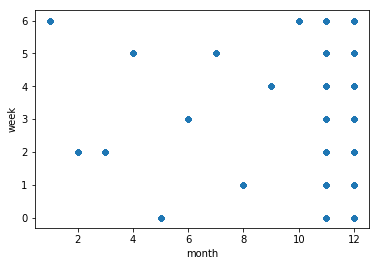

In [87]:
train_df['year'] = train_df['time1'].apply(lambda ts: int(ts.strftime('%Y')))
train_df['month'] = train_df['time1'].apply(lambda ts: int(ts.strftime('%-m')))
train_df['week'] = train_df['time1'].apply(lambda ts: int(ts.strftime('%w')))
train_df['hour'] = train_df['time1'].apply(lambda ts: int(ts.strftime('%-H')))
t13 = train_df[train_df['year'] == 2013]
t13.plot.scatter(x='month', y='week')

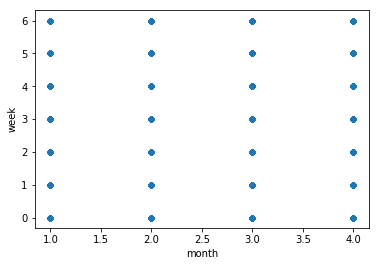

In [88]:
t14 = train_df[train_df['year'] == 2014]
t14.plot.scatter(x='month', y='week')

Вывод: Можно удалять старые данные до 10.2013 включительно. Так как пользователь которого мы идетефицируем до этой даты вел себя иначе.

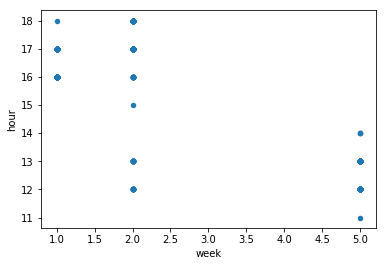

In [89]:
train2013 = train_df[(train_df['month'] > 10) & (train_df['year'] == 2013)]
train2014 = train_df[train_df['year'] == 2014]
train2013[train2013['target'] == 1].plot.scatter(x='week', y='hour')

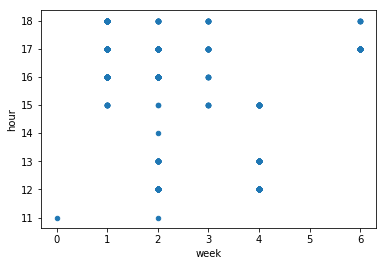

In [90]:
train2014[train2014['target'] == 1].plot.scatter(x='week', y='hour')

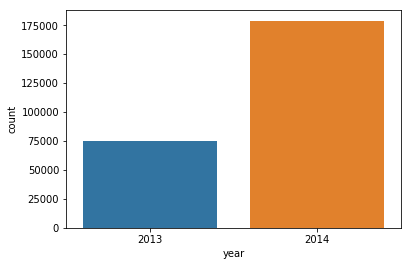

In [95]:
sns.countplot(train_df['year'])
plt.show()

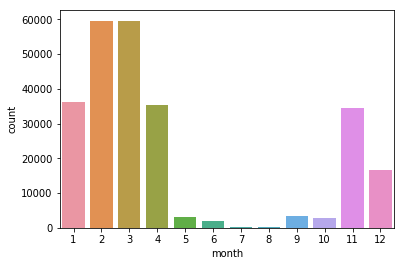

In [97]:
sns.countplot(train_df['month'])
plt.show()

## 6. Обучение модели

In [125]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [127]:
train_test_df = pd.concat([train_df, test_df])
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [55]:
def transform_to_csr_matrix(array):
    data = []
    r = [] #rows
    c = [] #cols
    for i in range(array.shape[0]):
        unique, counts = np.unique(array[i], return_counts=True)
        dic = dict(zip(unique, counts))
        r.extend([i]*len(dic.keys()))
        c.extend(dic.keys())
        data.extend(dic.values())
    
    coo = coo_matrix((data, (r, c)))
    dropped_data = np.in1d(coo.col, [0])
    coo.data = coo.data[~dropped_data]
    coo.row = coo.row[~dropped_data]
    coo.col = coo.col[~dropped_data]
    
    return coo.tocsr()

In [56]:
train_test_sparse = transform_to_csr_matrix(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]
y = train_df['target']

Посмотрим на размерности матриц *X_train_sparse* и *X_test_sparse

In [57]:
print(X_train_sparse.shape[0], X_train_sparse.shape[1], X_test_sparse.shape[0], X_test_sparse.shape[1])

253561 48372 82797 48372


Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.

In [59]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

### SGD Classifier

In [60]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.

In [61]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

Посчитаем ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке.

In [62]:
print('ROC AUC: {:.3f}'.format(roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])))

ROC AUC: 0.934


Сделаем прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).

In [63]:
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

Запишем ответы в файл и сделаем посылку на Kaggle.

In [64]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [65]:
write_to_submission_file(logit_test_pred_proba[:, 1], 'subm_kaggle.csv')

### Подбор параметров для SGDClassifier

In [125]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': np.linspace(0.00001, 0.0001, num = 100)
}

In [126]:
grid = GridSearchCV(sgd_logit, parameters_grid, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': array([1.00000e-05, 1.09091e-05, ..., 9.90909e-05, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**Посмотрим на лучшую модель и ее ROC AUC.**

In [127]:
grid.best_estimator_

SGDClassifier(alpha=6.090909090909091e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [128]:
print(grid.best_score_)
print(grid.best_params_)

0.9913460888378067
{'alpha': 6.090909090909091e-05, 'penalty': 'l2'}


In [129]:
roc_auc_score(y_valid, grid.best_estimator_.predict_proba(X_valid)[:, 1])

0.9429857055336716

**Кросс-валидация**

In [130]:
cv_score = cross_val_score(grid.best_estimator_, X_train, y_train,
                scoring='roc_auc', cv=5, n_jobs=-1)

In [131]:
print(cv_score.mean())

0.9418862841845401


**Обучим модель на всех данных.** 

In [76]:
grid.best_estimator_.fit(X_train_sparse, y)

SGDClassifier(alpha=6.090909090909091e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Сделаем прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки.**

In [77]:
best_sgd_test_pred_proba = grid.best_estimator_.predict_proba(X_test_sparse)

**Запишем ответы в файл и сделаем посылку на Kaggle.**

In [78]:
write_to_submission_file(best_sgd_test_pred_proba[:, 1], 'subm_kaggle_2.csv')

## 7. Кривые валидации и обучения

### Кривая валидации

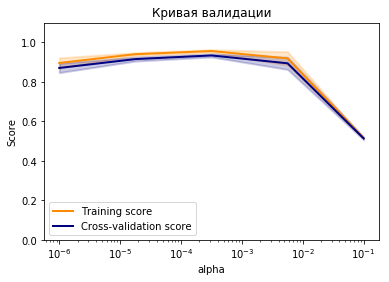

In [116]:
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SGDClassifier(), 
    param_name="alpha", param_range=param_range,
    X = X_train, y = y_train,
    cv=5, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Кривая валидации")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Кривая обучения

In [111]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/vitaly/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

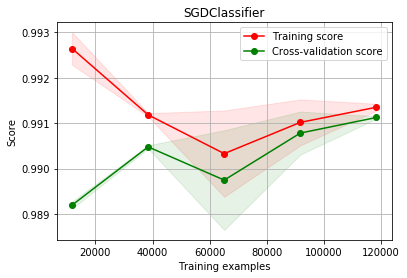

In [110]:
plot_learning_curve(SGDClassifier(alpha=6.090909090909091e-05, penalty = 'l1',random_state=17, n_jobs=-1),
                    'SGDClassifier', X_train, y_train)

Видно, что при увеличении размера датасета качество растет.

## 8. Выводы и оценка модели

В ходе проекта ставилась задачи идентификации одного пользователя среди многих. Классы были не сбалансированы и опираться на точность (accuracy) при оценки моделей мы не стали. Здесь лучше подойдет площадь под ROC кривой (AUC ROC). Используя это показатель при переборе параметров по сетке, удалось добиться высоких значений AUC ROC.  
Чтобы улучшить модель, можно собрать больше данных и сделать их более однородными.